In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load data
df = pd.read_csv('https://raw.githubusercontent.com/stevechengnyc/meta_learners/refs/heads/main/peacock_user_data_propensity.csv')
df.head(100)

,user_id,tenure_months,prior_engagement_score,weekly_watch_hours,num_devices,device_type,payment_method,account_type,has_kids_profile,region,promo_eligible,assigned_promo
0,0,3,0.323,1.8,5,tablet,apple_pay,ad_supported,0,northeast,1,1
1,1,29,0.086,3.8,2,smart_tv,gift_card,premium,0,midwest,1,1
2,2,35,0.435,3.8,3,smart_tv,apple_pay,student_discount,0,northeast,1,0
3,3,18,0.079,3.3,3,web,gift_card,premium,0,northeast,1,1
4,4,20,0.310,2.8,2,mobile,gift_card,ad_supported,0,south,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,4,0.123,2.0,5,mobile,credit_card,premium,1,northeast,1,1
96,96,8,0.057,4.9,4,web,gift_card,ad_supported,1,west,1,1
97,97,25,0.149,4.5,4,smart_tv,paypal,ad_supported,0,midwest,1,1
98,98,7,0.226,2.6,3,tablet,credit_card,premium,1,west,1,1


In [7]:
df.shape

(5000, 12)

In [6]:
df.dtypes

,0
user_id,int64
tenure_months,int64
prior_engagement_score,float64
weekly_watch_hours,float64
num_devices,int64
device_type,object
payment_method,object
account_type,object
has_kids_profile,int64
region,object


In [10]:
df.head()

,user_id,tenure_months,prior_engagement_score,weekly_watch_hours,num_devices,device_type,payment_method,account_type,has_kids_profile,region,promo_eligible,assigned_promo
0,0,3,0.323,1.8,5,tablet,apple_pay,ad_supported,0,northeast,1,1
1,1,29,0.086,3.8,2,smart_tv,gift_card,premium,0,midwest,1,1
2,2,35,0.435,3.8,3,smart_tv,apple_pay,student_discount,0,northeast,1,0
3,3,18,0.079,3.3,3,web,gift_card,premium,0,northeast,1,1
4,4,20,0.310,2.8,2,mobile,gift_card,ad_supported,0,south,1,1


In [11]:
df[df['promo_eligible'] == 0]['user_id'].nunique()

978

In [12]:
df[df['promo_eligible'] == 1]['user_id'].nunique()

4022

In [13]:
df[df['promo_eligible'] == 0]['user_id'].count()

np.int64(978)

In [14]:
df[df['promo_eligible'] == 0]['user_id'].size()

TypeError: 'int' object is not callable

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [04:32:48] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



{title} AUC: {auc:.4f}
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       483
           1       0.88      0.95      0.91      1017

    accuracy                           0.87      1500
   macro avg       0.87      0.83      0.85      1500
weighted avg       0.87      0.87      0.87      1500


{title} AUC: {auc:.4f}
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       483
           1       0.90      0.92      0.91      1017

    accuracy                           0.88      1500
   macro avg       0.86      0.85      0.86      1500
weighted avg       0.87      0.88      0.88      1500



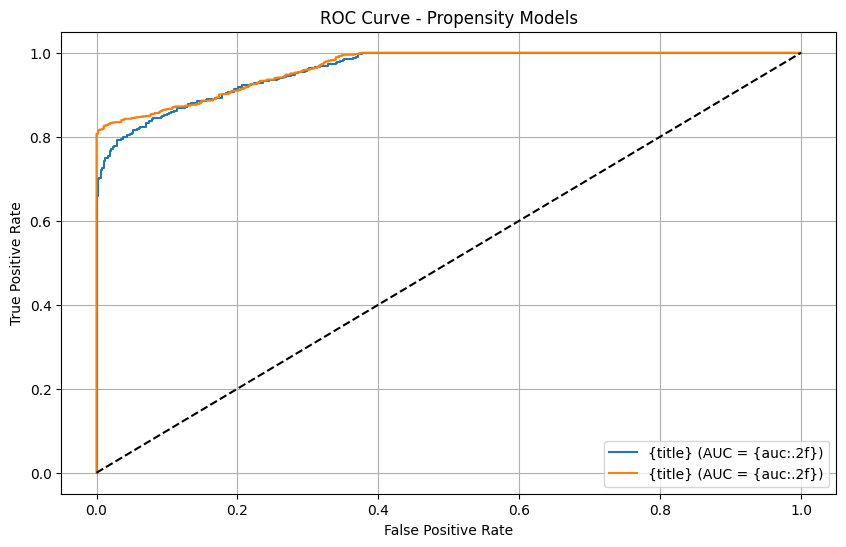

In [4]:
# Features and target
X = df.drop(columns=["user_id", "assigned_promo"])
y = df["assigned_promo"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Preprocessing
numeric_features = ["tenure_months", "prior_engagement_score"]
categorical_features = ["device_type", "payment_method", "promo_eligible"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
])

# Train models
lr_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Evaluate
def evaluate(model, X_test, y_test, title):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n{{title}} AUC: {{auc:.4f}}")
    print(classification_report(y_test, model.predict(X_test)))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{{title}} (AUC = {{auc:.2f}})")

plt.figure(figsize=(10, 6))
evaluate(lr_pipeline, X_test, y_test, "Logistic Regression")
evaluate(xgb_pipeline, X_test, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Propensity Models")
plt.legend()
plt.grid(True)
plt.show()

In [1]:

# # Propensity Score Modeling for Peacock Promo Email
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
df = pd.read_csv("peacock_user_data.csv")

# Features and target
X = df.drop(columns=["user_id", "assigned_promo"])
y = df["assigned_promo"]

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

# Preprocessing
numeric_features = ["tenure_months", "prior_engagement_score"]
categorical_features = ["device_type", "payment_method", "promo_eligible"]

preprocessor = ColumnTransformer([
    ("num", StandardScaler(), numeric_features),
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features)
])

# Logistic Regression Pipeline
lr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=1000))
])

# XGBoost Pipeline
xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("classifier", XGBClassifier(use_label_encoder=False, eval_metric="logloss"))
])

# Train models
lr_pipeline.fit(X_train, y_train)
xgb_pipeline.fit(X_train, y_train)

# Evaluate
def evaluate(model, X_test, y_test, title):
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    print(f"\n{{title}} AUC: {{auc:.4f}}")
    print(classification_report(y_test, model.predict(X_test)))

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f"{{title}} (AUC = {{auc:.2f}})")

plt.figure(figsize=(10, 6))
evaluate(lr_pipeline, X_test, y_test, "Logistic Regression")
evaluate(xgb_pipeline, X_test, y_test, "XGBoost")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Propensity Models")
plt.legend()
plt.grid(True)
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: 'peacock_user_data.csv'